## 知識情報学第5回演習サンプルプログラム ex5.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2017/11/02
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT Lisence

## ロジスティック回帰による手書き文字認識
- MNISTデータセットについては，詳しくは下記を参照
  - http://yann.lecun.com/exdb/mnist/
  - (注) httpsはアクセス不可．Chrome以外のブラウザを使用すること

In [1]:
%matplotlib inline
import os
import struct
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

### MNISTデータの読み込み関数

In [2]:
def load_mnist(path, kind='train'):

    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

### MNISTデータの読み込み

In [3]:
current_path = os.path.dirname(os.path.realpath('__file__'))
X_train, y_train = load_mnist(current_path, kind='train')
X_test, y_test = load_mnist(current_path, kind='t10k')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kio\\OneDrive - OUMail (Osaka University)\\M1\\Knowledge_Informatics\\train-labels.idx1-ubyte'

In [4]:
# 学習用に最初の1000点，テスト用に最初の1000点のデータを使用
# 動作が遅い場合は，学習データを小さくして下さい
X_train = X_train[:1000][:]
y_train = y_train[:1000][:]
X_test = X_test[:1000][:]
y_test = y_test[:1000][:]
print('#data: %d, #feature: %d (training data)' % (X_train.shape[0], X_train.shape[1]))
print('#data: %d, #feature: %d (test data)' % (X_test.shape[0], X_test.shape[1]))

#data: 1000, #feature: 784 (training data)
#data: 1000, #feature: 784 (test data)


### ロジスティック回帰のインスタンスの生成と学習
- 3クラス以上のマルチクラスへの対応は、multi_classで指定する。ovr(one-versus-rest)法は、1対多でクラス数分の識別器を構築し、テストデータのクラス分類は最も事後確率の高いクラスへ分類する方式。

In [5]:
lr = LogisticRegression(penalty='l2', C=1000.0, random_state=0, solver='liblinear', multi_class='ovr')
lr.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### 学習データおよびテストデータに対するaccuracyの算出

In [6]:
y_train_pred = lr.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0)*100 / X_train.shape[0]
print('accuracy for training data: %.2f%%' % acc)

y_test_pred = lr.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0)*100 / X_test.shape[0]
print('accuracy for test data: %.2f%%' % acc)

accuracy for training data: 100.00%
accuracy for test data: 81.70%


### 最初の25サンプルの識別結果をプロット
t: 正解クラス，p: 識別器による推測クラス

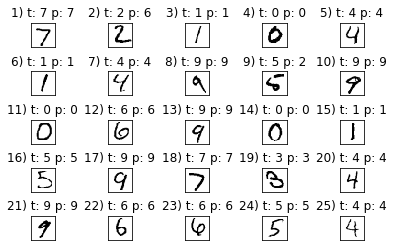

In [7]:
orign_img = X_test[:25]
true_lab = y_test[:25]
predicted_lab = y_test_pred[:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = orign_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, true_lab[i], predicted_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.subplots_adjust(hspace=1.0, wspace=2.0)
plt.show()

### パラメータを変化させてロジスティック回帰の挙動を観察する
- 【課題1a】逆正則化パラメータ（スライドのλの逆数）を10^-10から10^10まで10倍ずつ変化させたときの、非ゼロの重みの数とAccuracyをグラフにプロット
- 【課題2】引数penaltyを変更して，L1,L2正則化の効果を考察する．

In [8]:
n_nonzero_weights, params, accuracy_train, accuracy_test = [], [], [], []
for c in np.arange(-10, 11, dtype=float):
    # 逆正則化パラメータ
    param = 10**c
    
    # ロジスティック回帰のインスタンスを生成し，学習データに対して適合させる．
    [YOUR CODE HERE]
    
    # 非ゼロの重みの数をn_nonzero_weightsに追加．one-vs-restのいずれかの一つのクラスに対応する重みのみで良い．
    # ヒント：学習済みの重みはcoef_[]に格納されている．また，非ゼロの要素数はnumpyのcount_nonzero()を使うと良い
    [YOUR CODE HERE]
    
    # 学習データおよびテストデータに対するAccuracyをaccuracy_train，accuracy_testに追加
    [YOUR CODE HERE]
    
    params.append(param)

### 分類精度のグラフ出力

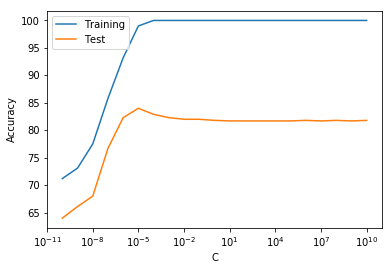

In [9]:
plt.plot(params, accuracy_train,label='Training')
plt.plot(params, accuracy_test, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()
#下記は実行例

### 非ゼロ重みの数のグラフ出力

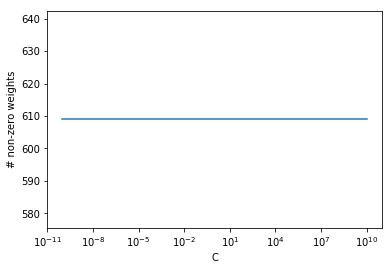

In [10]:
plt.plot(params, n_nonzero_weights)
plt.ylabel('# non-zero weights')
plt.xlabel('C')
plt.xscale('log')
plt.show()
#下記は実行例

### 【課題1b】学習済み重みの2次元プロット
- いずれかひとつのクラスのみで良い

In [ ]:
[YOUR CODE HERE]